In [33]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf

from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

In [34]:
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

In [35]:
path = tf.keras.utils.get_file('daily-min-temperatures.csv', 
                               'https://raw.githubusercontent.com/jbrownlee/Datasets/master/daily-min-temperatures.csv')
print (path)

C:\Users\Amir\.keras\datasets\daily-min-temperatures.csv


In [36]:
df = pd.read_csv(path, index_col='Date', parse_dates=True)

In [37]:
df.head()

,Temp
Date,
1981-01-01,20.7
1981-01-02,17.9
1981-01-03,18.8
1981-01-04,14.6
1981-01-05,15.8


<AxesSubplot:xlabel='Date'>

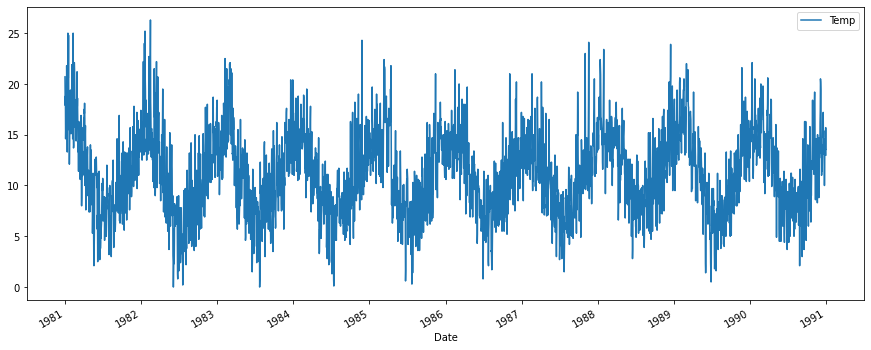

In [38]:
df.plot(figsize=(15,6))

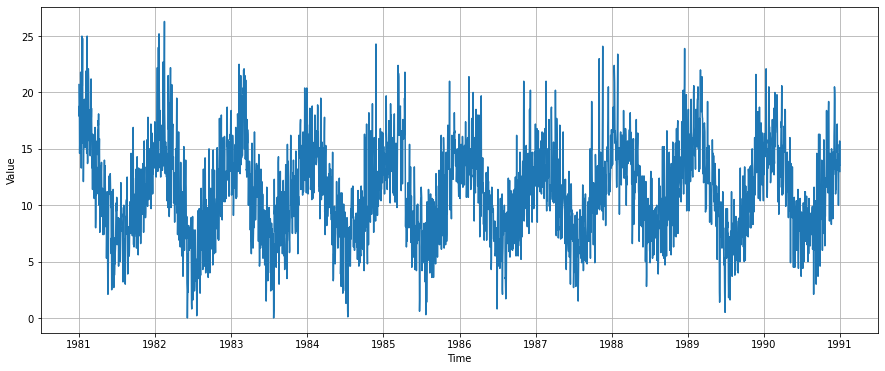

In [39]:
series = np.array(df['Temp'],float)
time = np.array(df.index)
plt.figure(figsize=(15, 6))
plot_series(time, series)

In [40]:
split_time = 2500
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

In [41]:
window_size = 30
batch_size = 32
n_features = 1

In [42]:
# needed for lstm model.
x_train = x_train.reshape((len(x_train), n_features))
x_train.shape

(2500, 1)

In [43]:
generator = TimeseriesGenerator(x_train, x_train,
                                length = window_size, sampling_rate = 1, 
                                batch_size = batch_size, shuffle = True)

In [44]:
x_train.shape

(2500, 1)

In [45]:
def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

In [46]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)

In [47]:
window_size = 64
batch_size = 256

In [48]:
generator = TimeseriesGenerator(x_train, x_train,
                                length = window_size, sampling_rate = 1, 
                                batch_size = batch_size, shuffle = True)

In [49]:
len(generator)

10

In [50]:
x, y = generator[1]
x.shape

(256, 64, 1)

In [51]:
# CNN here

model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=32, kernel_size=5,
                      strides=1, padding="same",  # ="causal",
                      activation="relu",
                      input_shape=[None, 1]),
  tf.keras.layers.LSTM(64, return_sequences=True),
  tf.keras.layers.LSTM(64, return_sequences=True),
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 400)
])

In [52]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, None, 32)          192       
_________________________________________________________________
lstm (LSTM)                  (None, None, 64)          24832     
_________________________________________________________________
lstm_1 (LSTM)                (None, None, 64)          33024     
_________________________________________________________________
dense (Dense)                (None, None, 30)          1950      
_________________________________________________________________
dense_1 (Dense)              (None, None, 10)          310       
_________________________________________________________________
dense_2 (Dense)              (None, None, 1)           11        
_________________________________________________________________
lambda (Lambda)              (None, None, 1)           0

In [53]:
lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))

In [54]:
optimizer = tf.keras.optimizers.SGD(lr=1e-8, momentum=0.9)

In [55]:
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

In [56]:
history = model.fit(generator, epochs=100, callbacks=[lr_schedule])

Epoch 1/100
10/10 [==============================] - 3s 284ms/step - loss: 279.1299 - mae: 279.6299
Epoch 2/100
10/10 [==============================] - 3s 251ms/step - loss: 268.5157 - mae: 269.0157
Epoch 3/100
10/10 [==============================] - 2s 244ms/step - loss: 254.0854 - mae: 254.5854
Epoch 4/100
10/10 [==============================] - 3s 261ms/step - loss: 236.9418 - mae: 237.4418
Epoch 5/100
10/10 [==============================] - 3s 265ms/step - loss: 217.4931 - mae: 217.9931
Epoch 6/100
10/10 [==============================] - 2s 249ms/step - loss: 195.8368 - mae: 196.3368
Epoch 7/100
10/10 [==============================] - 3s 253ms/step - loss: 175.0006 - mae: 175.5006
Epoch 8/100
10/10 [==============================] - 2s 231ms/step - loss: 152.1317 - mae: 152.6317
Epoch 9/100
10/10 [==============================] - 2s 241ms/step - loss: 131.4673 - mae: 131.9673
Epoch 10/100
10/10 [==============================] - 2s 238ms/step - loss: 115.8143 - mae: 116.3143

(1e-08, 0.0001, 0.0, 60.0)

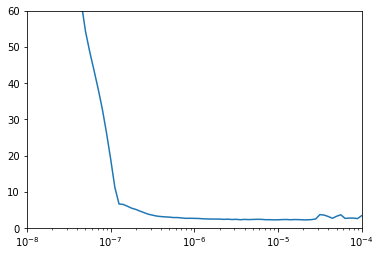

In [57]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-8, 1e-4, 0, 60])

In [58]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)

In [59]:
generator = TimeseriesGenerator(x_train, x_train,
                                length = 60, 
                                batch_size = 100, shuffle=True)

In [60]:
model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=60, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
  tf.keras.layers.LSTM(60, return_sequences=True),
  tf.keras.layers.LSTM(60, return_sequences=True),
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 400)
])

In [61]:
optimizer = tf.keras.optimizers.SGD(lr=1e-5, momentum=0.9)

In [62]:
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

In [64]:
history = model.fit(generator,epochs=150)

Epoch 1/150
25/25 [==============================] - 3s 124ms/step - loss: 21.6205 - mae: 22.1018
Epoch 2/150
25/25 [==============================] - ETA: 0s - loss: 2.8594 - mae: 3.324 - 4s 153ms/step - loss: 2.8594 - mae: 3.3249
Epoch 3/150
25/25 [==============================] - 4s 160ms/step - loss: 2.6447 - mae: 3.1085
Epoch 4/150
25/25 [==============================] - 3s 128ms/step - loss: 2.4075 - mae: 2.8688
Epoch 5/150
25/25 [==============================] - 3s 127ms/step - loss: 2.2700 - mae: 2.7290
Epoch 6/150
25/25 [==============================] - 4s 141ms/step - loss: 2.3477 - mae: 2.8081
Epoch 7/150
25/25 [==============================] - 3s 137ms/step - loss: 2.5030 - mae: 2.9664
Epoch 8/150
25/25 [==============================] - 3s 107ms/step - loss: 2.4090 - mae: 2.8700
Epoch 9/150
25/25 [==============================] - 3s 107ms/step - loss: 2.3541 - mae: 2.8154
Epoch 10/150
25/25 [==============================] - 3s 111ms/step - loss: 2.3767 - mae: 2.8384

In [65]:
rnn_forecast = model_forecast(model, series[..., np.newaxis], window_size)
rnn_forecast = rnn_forecast[split_time - window_size:-1, -1, 0]

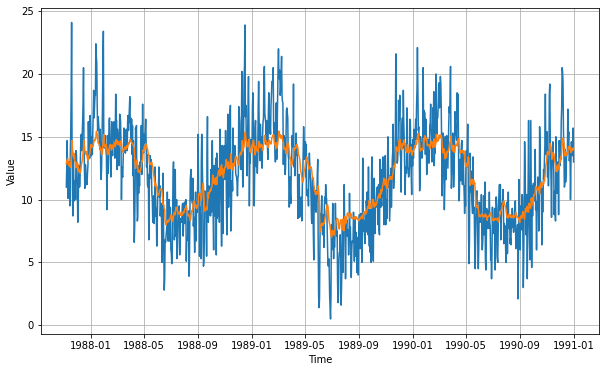

In [66]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, rnn_forecast)

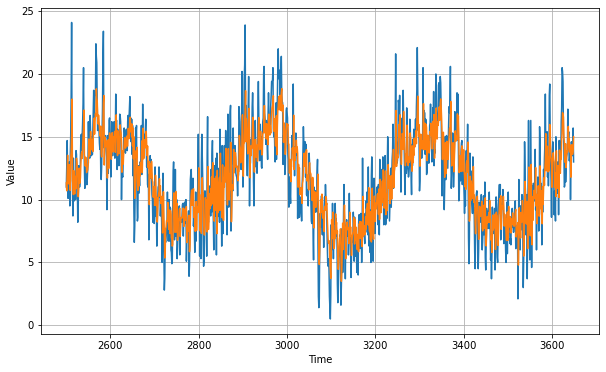

In [67]:
tf.keras.metrics.mean_absolute_error(x_valid, rnn_forecast).numpy()

2.0456688

In [68]:
print(rnn_forecast)

[12.849152 13.105371 13.114577 ... 14.002222 13.968956 14.142841]
